In [1]:
import pandas as pd
pd.set_option('display.max_columns', 40)

import numpy as np
import datetime
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from pathlib import Path
import sys

PATH = '/Users/danil/Documents/github/appflame'
sys.path.append(str(PATH))

from src.appflame import score_models, Neural_Network, train_nn_on_fold, check_confusion_matrix, show_comparing_table

In [2]:
RANDOM_SEED = 42
CV_FOLDS = 3

In [3]:
df = pd.read_csv(PATH + '/data/raw/df.csv')

print(df.shape)
df.head()

(284807, 33)


,is_fraud,transaction_amount,relative_timestamp,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30
0,0,118.44,159609.0,1.928977,-0.745709,-1.742981,-0.247731,-0.379232,-1.504379,0.426988,-0.560930,-1.346733,1.047987,1.336412,1.404223,1.062332,0.470407,-1.328266,-2.153751,0.080569,0.738571,-0.566688,-0.348429,-0.096171,0.153526,-0.001283,0.631590,0.130582,0.758711,-0.113741,-0.063939,0.795595,-2.200074
1,0,1.98,162525.0,2.060450,-0.136926,-1.085910,0.430300,-0.254977,-1.247417,0.104193,-0.267854,0.721569,0.108246,-0.936630,-0.193028,-1.130690,0.513458,0.170295,-0.051804,-0.216638,-0.726115,0.150763,-0.300772,-0.302288,-0.795267,0.355477,0.013651,-0.340015,0.199361,-0.078557,-0.062377,0.921937,0.216959
2,0,103.00,58956.0,1.114014,-1.533296,0.741385,-1.385897,-1.241643,1.088519,-1.433041,0.390210,-1.711226,1.180505,0.808971,-0.194381,0.899373,-0.422711,1.870341,-1.518903,1.674176,-1.777327,-2.147259,-0.254369,0.140363,0.783574,0.082555,-0.615175,-0.036441,-0.006456,0.109368,0.032635,0.225000,-2.467540
3,0,16.70,148842.0,0.514410,1.389934,-1.091181,1.604760,0.460984,-0.381953,-0.599145,-2.721896,-0.567445,-1.458127,0.125269,-0.445574,-1.347590,-1.198823,1.026539,0.531775,1.904563,0.543099,-0.324569,0.595534,-1.670931,-0.854670,0.130428,0.789378,0.909599,-0.692159,-0.033316,0.096833,0.586722,1.187643
4,0,110.14,125542.0,-0.849330,0.399191,-0.319642,-1.220384,1.062371,1.752440,0.558836,0.895163,-0.241615,-1.275903,0.391643,1.113145,0.105190,0.527055,-0.633773,-0.869942,0.258944,-1.019820,-0.281717,-0.048197,0.134113,0.278606,0.198983,-0.936208,-0.477630,-0.087217,0.035566,0.090183,0.569712,-1.485808


check class balances

In [4]:
df['is_fraud'].value_counts() / df.shape[0]

0    0.998273
1    0.001727
Name: is_fraud, dtype: float64

this dataset is most unbalanced that I ever saw, haha))

lets go deeper, and check time frames with other feature params

In [5]:
np.round(df.describe(), 2)

,is_fraud,transaction_amount,relative_timestamp,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,279037.00,273152.00
mean,0.00,88.35,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00
std,0.04,250.12,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,1.09,1.02,1.00,1.00,0.96,0.92,0.88,0.85,0.84,0.81,0.77,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,0.58,1.73
min,0.00,0.00,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,-24.59,-4.80,-18.68,-5.79,-19.21,-4.50,-14.13,-25.16,-9.50,-7.21,-54.50,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,-1.00,-3.00
25%,0.00,5.60,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,-0.54,-0.76,-0.41,-0.65,-0.43,-0.58,-0.47,-0.48,-0.50,-0.46,-0.21,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,-0.50,-1.50
50%,0.00,22.00,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,-0.09,-0.03,0.14,-0.01,0.05,0.05,0.07,-0.07,-0.00,0.00,-0.06,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,0.00,0.01
75%,0.00,77.16,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,0.45,0.74,0.62,0.66,0.49,0.65,0.52,0.40,0.50,0.46,0.13,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,0.50,1.50
max,1.00,25691.16,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,23.75,12.02,7.85,7.13,10.53,8.88,17.32,9.25,5.04,5.59,39.42,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,1.00,3.00


check missed values

In [6]:
df.isnull().sum()

is_fraud                  0
transaction_amount        0
relative_timestamp        0
F1                        0
F2                        0
F3                        0
F4                        0
F5                        0
F6                        0
F7                        0
F8                        0
F9                        0
F10                       0
F11                       0
F12                       0
F13                       0
F14                       0
F15                       0
F16                       0
F17                       0
F18                       0
F19                       0
F20                       0
F21                       0
F22                       0
F23                       0
F24                       0
F25                       0
F26                       0
F27                       0
F28                       0
F29                    5770
F30                   11655
dtype: int64

good to see that only 2 features have missed values, I preffer to use median value for missing values

In [7]:
df = df.fillna(df.median())

check how features correlate with each other

In [8]:
corr = df.corr()

corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,is_fraud,transaction_amount,relative_timestamp,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30
is_fraud,1.00,0.01,-0.01,-0.10,0.09,-0.19,0.13,-0.09,-0.04,-0.19,0.02,-0.10,-0.22,0.15,-0.26,-0.00,-0.30,-0.00,-0.20,-0.33,-0.11,0.03,0.02,0.04,0.00,-0.00,-0.01,0.00,0.00,0.02,0.01,0.00,0.00
transaction_amount,0.01,1.00,-0.01,-0.23,-0.53,-0.21,0.10,-0.39,0.22,0.40,-0.10,-0.04,-0.10,0.00,-0.01,0.01,0.03,-0.00,-0.00,0.01,0.04,-0.06,0.34,0.11,-0.06,-0.11,0.01,-0.05,-0.00,0.03,0.01,-0.00,0.00
relative_timestamp,-0.01,-0.01,1.00,0.12,-0.01,-0.42,-0.11,0.17,-0.06,0.08,-0.04,-0.01,0.03,-0.25,0.12,-0.07,-0.10,-0.18,0.01,-0.07,0.09,0.03,-0.05,0.04,0.14,0.05,-0.02,-0.23,-0.04,-0.01,-0.01,-0.00,-0.00
F1,-0.10,-0.23,0.12,1.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.01,0.00
F2,0.09,-0.53,-0.01,-0.00,1.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00
F3,-0.19,-0.21,-0.42,-0.00,0.00,1.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00
F4,0.13,0.10,-0.11,-0.00,-0.00,-0.00,1.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00
F5,-0.09,-0.39,0.17,0.00,0.00,-0.00,-0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00
F6,-0.04,0.22,-0.06,0.00,0.00,0.00,-0.00,0.00,1.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00
F7,-0.19,0.40,0.08,0.00,-0.00,0.00,0.00,0.00,-0.00,1.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00


drop useless timestemp

In [9]:
df = df.drop('relative_timestamp', 1)

plot features distribution

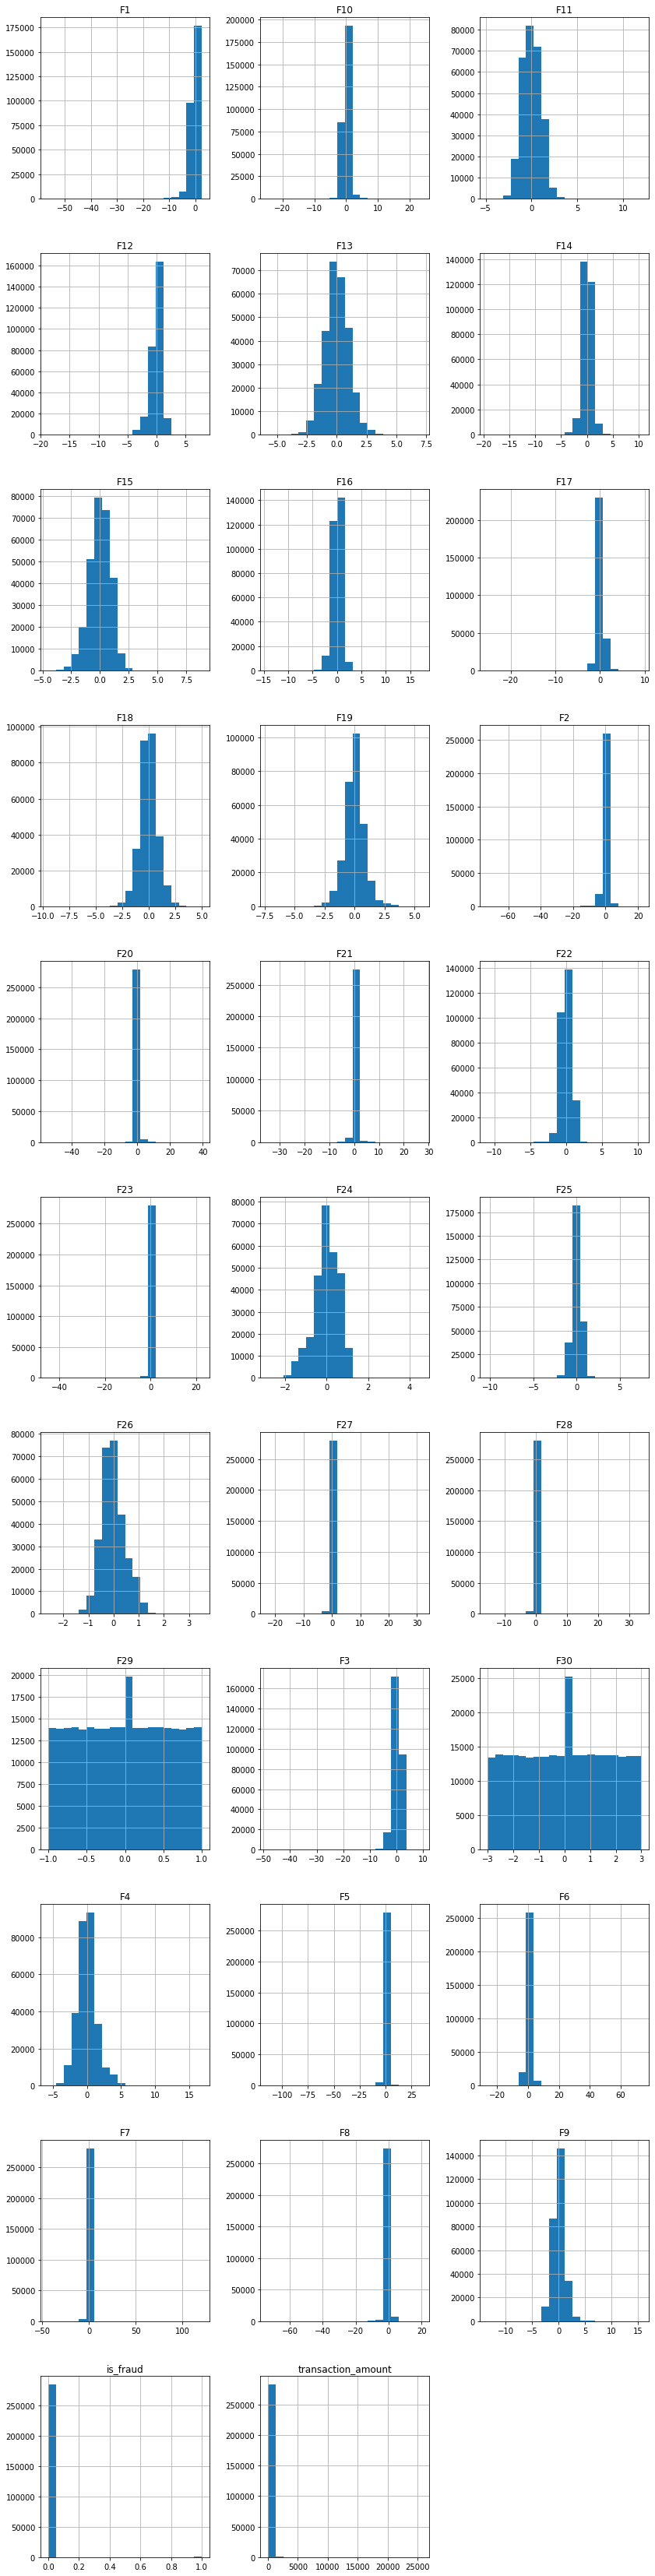

In [10]:
df.hist(layout=(11, 3), figsize=(14, 60), bins=20);

as we can see there are some features have anomaly observations and it looks like some issue with data tracking (it was on my first view, further I understand that all fine for now)

In [11]:
features_to_filter = [
    'F5', 'F6', 'F7', 'F8', 'F28', 'F27', 'F20', 'F21', 'F23', 'F1', 'F10',
    'F17', 'F2'
]

for each feature I will replace anomaly value (for better score we have to check every feature separately) with quantile value

In [12]:
# just to be safe
df_origin = df.copy()

In [13]:
anomaly_df = pd.DataFrame(
    np.where((df[features_to_filter] < df[features_to_filter].quantile(.99)) &
             (df[features_to_filter] > df[features_to_filter].quantile(.01)),
             df[features_to_filter], np.nan))

print(anomaly_df.isnull().sum(1)[anomaly_df.isnull().sum(1) >= 1].shape)
idx = anomaly_df.isnull().sum(1)[anomaly_df.isnull().sum(1) >= 1].index

df.iloc[idx]['is_fraud'].value_counts()

(32720,)


0    32283
1      437
Name: is_fraud, dtype: int64

In [14]:
df['is_fraud'].sum()

492

In [15]:
437 / 492

0.8882113821138211

we can make conclusion that more than 88% fraud operations have anomaly high or low values

at the start I thought to remove anomaly observation, but now I can use it like feature. 

In [16]:
df['anomaly'] = 0
df.loc[idx, 'anomaly'] = 1

In [17]:
df[features_to_filter] = np.where(
    df[features_to_filter] < df[features_to_filter].quantile(.99),
    df[features_to_filter], df[features_to_filter].quantile(.99))

df[features_to_filter] = np.where(
    df[features_to_filter] > df[features_to_filter].quantile(.01),
    df[features_to_filter], df[features_to_filter].quantile(.01))

df.isnull().sum().sum()

0

logarythm doesnt fit here, because of negative values, so I will apply only standartization. Usually log can help pretty much

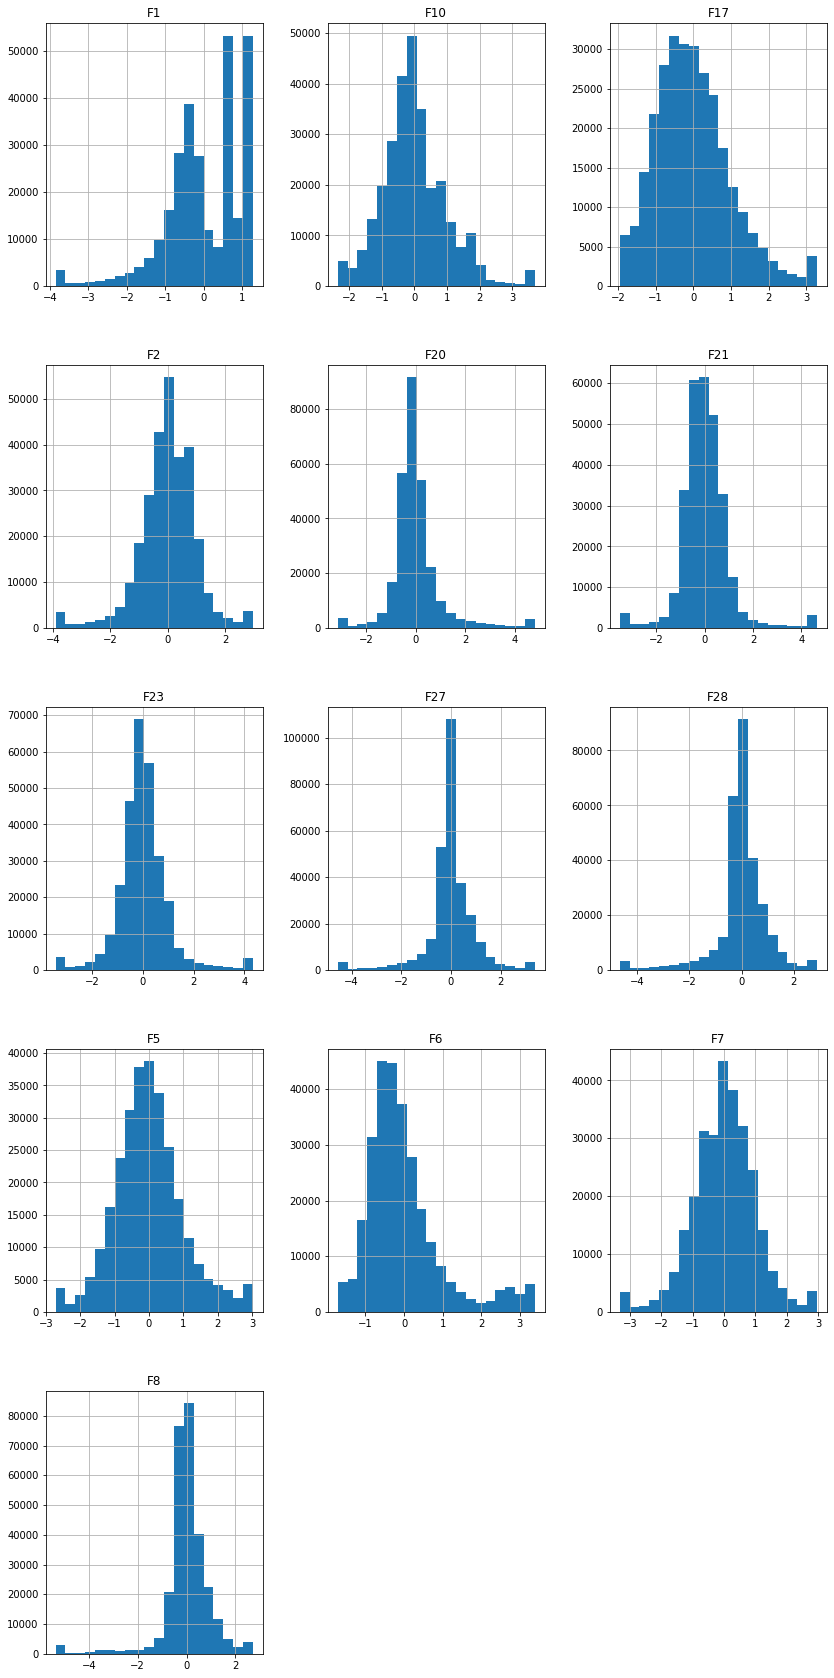

In [18]:
scaler = StandardScaler()

df[features_to_filter] = scaler.fit_transform(df[features_to_filter])

df[features_to_filter].hist(layout=(5, 3), figsize=(14, 30), bins=20);

now looks better

split dataset to train and test with ratio 0.2

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('is_fraud', 1),
                                                    df['is_fraud'],
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

In [20]:
y_train.value_counts() / y_train.shape[0]

0    0.99835
1    0.00165
Name: is_fraud, dtype: float64

better to use 7 cv_folds on prod level, but for brief and fast exploration it is enough

In [21]:
models = []

models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('LGBM', LGBMClassifier(is_unbalance=True, silent=True)))

accuracy_results = []
time_to_fit = []
names = []

In [22]:
accuracy_results, time_to_fit, names = score_models(models, X_train, y_train,
                                                        CV_FOLDS, accuracy_results,
                                                        time_to_fit, names)

LR: roc-auc mean: 0.960120 std: (0.011117), takes: 3.077711
LGBM: roc-auc mean: 0.901890 std: (0.022833), takes: 2.013483


for neural network we need to prepare data

In [22]:
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
min_max_scaler.fit(df.drop('is_fraud', 1))

MinMaxScaler(copy=True, feature_range=(-1, 1))

In [24]:
x_train_nn, x_test_nn = pd.DataFrame(
    min_max_scaler.transform(X_train)), pd.DataFrame(
        min_max_scaler.transform(X_test))

In [25]:
rows_per_fold = math.floor(x_train_nn.shape[0] / CV_FOLDS)

y_train_nn = y_train.reset_index().drop('index', 1)
results = []
learning_time = []

for i in range(CV_FOLDS):
    nn = Neural_Network()
    res = train_nn_on_fold(nn, x_train_nn, y_train_nn, i, rows_per_fold)
    results.append(res[0])
    learning_time.append(res[1])

time_to_fit.append(learning_time)
accuracy_results.append(results)
names.append('Neural_network')

Train on 151897 samples
151897/151897 [==============================] - 11s 69us/sample - loss: 0.0061 - AUC: 0.9071s - loss: 0.0115 - AUC: 0.89 - ETA: - ETA:
Train on 151897 samples
151897/151897 [==============================] - 11s 69us/sample - loss: 0.0046 - AUC: 0.9342
Train on 151897 samples
151897/151897 [==============================] - 11s 72us/sample - loss: 0.0058 - AUC: 0.9087s - loss: 0.0058 - AUC: 0.


In [26]:
show_comparing_table(names, accuracy_results, time_to_fit)

             name   roc-auc  time to learn
0              LR  0.960120       3.077711
1            LGBM  0.901890       2.013483
2  Neural_network  0.974123      12.333333


check confusion matrixes

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56846
           1       0.95      0.66      0.78       116

    accuracy                           1.00     56962
   macro avg       0.97      0.83      0.89     56962
weighted avg       1.00      1.00      1.00     56962



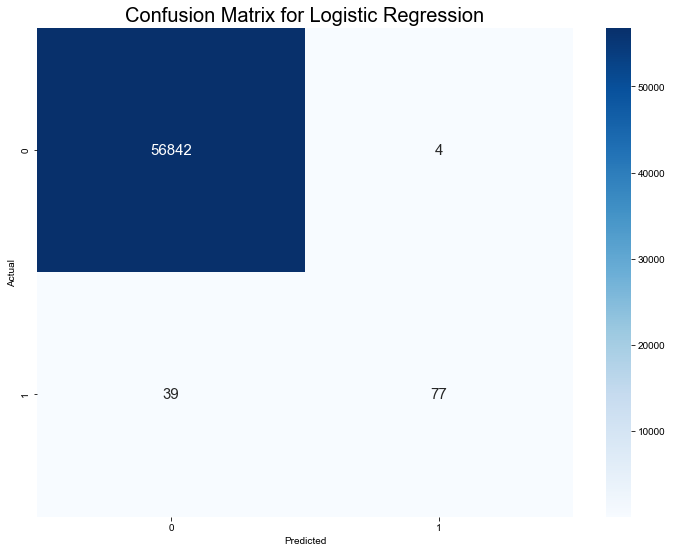

In [27]:
lr = LogisticRegression(solver='liblinear')
check_confusion_matrix(lr, X_train, X_test, y_train, y_test,
                       'Logistic Regression')

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56846
           1       0.04      0.84      0.08       116

    accuracy                           0.96     56962
   macro avg       0.52      0.90      0.53     56962
weighted avg       1.00      0.96      0.98     56962



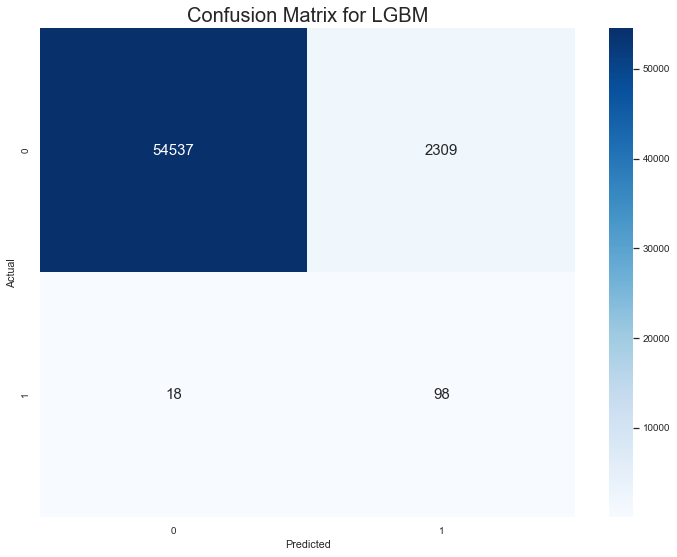

In [28]:
LGBM = LGBMClassifier(is_unbalance=True, silent=True)
check_confusion_matrix(LGBM, X_train, X_test, y_train, y_test, 'LGBM')

Train on 227845 samples
227845/227845 [==============================] - 16s 69us/sample - loss: 0.0049 - AUC: 0.9234
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56846
           1       0.92      0.59      0.72       116

    accuracy                           1.00     56962
   macro avg       0.96      0.79      0.86     56962
weighted avg       1.00      1.00      1.00     56962



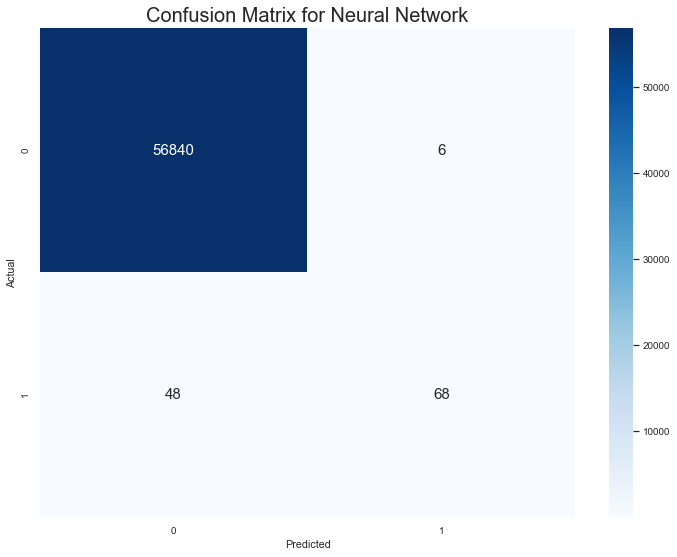

In [29]:
NN = Neural_Network()
check_confusion_matrix(NN, x_train_nn, x_test_nn, y_train, y_test,
                       'Neural Network')

oversampling

In [30]:
suffix = ' oversampling'

In [31]:
ros = RandomOverSampler(sampling_strategy=.3, random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(y_resampled.value_counts() / y_resampled.shape[0])
print(X_resampled.shape)

idx = np.random.permutation(X_resampled.index)
X_resampled = X_resampled.reindex(idx)
y_resampled = y_resampled.reindex(idx)

0    0.769233
1    0.230767
Name: is_fraud, dtype: float64
(295709, 32)


In [32]:
accuracy_results, time_to_fit, names = score_models(models,
                                                    X_resampled,
                                                    y_resampled,
                                                    CV_FOLDS,
                                                    accuracy_results,
                                                    time_to_fit,
                                                    names,
                                                    name_suffix=suffix)

LR: roc-auc mean: 0.986795 std: (0.000383), takes: 2.525783
LGBM: roc-auc mean: 0.999991 std: (0.000002), takes: 4.017877


In [33]:
x_train_nn = pd.DataFrame(min_max_scaler.transform(X_resampled))

In [34]:
rows_per_fold = math.floor(x_train_nn.shape[0] / CV_FOLDS)
#print(rows_per_fold)
y_train_nn = y_resampled.reset_index().drop('index', 1)
results = []
learning_time = []

for i in range(CV_FOLDS):
    nn = Neural_Network()
    res = train_nn_on_fold(nn, x_train_nn, y_train_nn, i, rows_per_fold)
    results.append(res[0])
    learning_time.append(res[1])

time_to_fit.append(learning_time)
accuracy_results.append(results)
names.append('Neural_network' + suffix)

Train on 197140 samples
197140/197140 [==============================] - 14s 71us/sample - loss: 0.0374 - AUC: 0.9981s - loss: 0.0375 - AUC: 0.99
Train on 197140 samples
197140/197140 [==============================] - 15s 74us/sample - loss: 0.0394 - AUC: 0.9978s - lo - ETA: 0s - loss: 0.0398 - AUC: 0
Train on 197140 samples
197140/197140 [==============================] - 14s 69us/sample - loss: 0.0358 - AUC: 0.9983


In [35]:
show_comparing_table(names, accuracy_results, time_to_fit)

                          name   roc-auc  time to learn
0                           LR  0.960120       3.077711
1                         LGBM  0.901890       2.013483
2               Neural_network  0.974123      12.333333
3              LR oversampling  0.986795       2.525783
4            LGBM oversampling  0.999991       4.017877
5  Neural_network oversampling  0.999826      16.333333


undersampling

In [36]:
suffix = ' undersampling'

In [37]:
rus = RandomUnderSampler(sampling_strategy=.3, random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
print(y_resampled.value_counts() / y_resampled.shape[0])
print(X_resampled.shape)

idx = np.random.permutation(X_resampled.index)
X_resampled = X_resampled.reindex(idx)
y_resampled = y_resampled.reindex(idx)

0    0.769184
1    0.230816
Name: is_fraud, dtype: float64
(1629, 32)


In [38]:
accuracy_results, time_to_fit, names = score_models(models,
                                                    X_resampled,
                                                    y_resampled,
                                                    CV_FOLDS,
                                                    accuracy_results,
                                                    time_to_fit,
                                                    names,
                                                    name_suffix=suffix)

LR: roc-auc mean: 0.977098 std: (0.006454), takes: 0.014880
LGBM: roc-auc mean: 0.981959 std: (0.003285), takes: 0.362925


In [39]:
x_train_nn = pd.DataFrame(min_max_scaler.transform(X_resampled))

In [40]:
rows_per_fold = math.floor(x_train_nn.shape[0] / CV_FOLDS)
#print(rows_per_fold)
y_train_nn = y_resampled
results = []
learning_time = []

for i in range(CV_FOLDS):
    nn = Neural_Network()
    res = train_nn_on_fold(nn, x_train_nn, y_train_nn, i, rows_per_fold)
    results.append(res[0])
    learning_time.append(res[1])

time_to_fit.append(learning_time)
accuracy_results.append(results)
names.append('Neural_network' + suffix)

Train on 1086 samples
1086/1086 [==============================] - 1s 675us/sample - loss: 0.6584 - AUC: 0.5169
Train on 1086 samples
1086/1086 [==============================] - 1s 660us/sample - loss: 0.6541 - AUC: 0.5184
Train on 1086 samples
1086/1086 [==============================] - 1s 672us/sample - loss: 0.2692 - AUC: 0.0000e+00


In [41]:
show_comparing_table(names, accuracy_results, time_to_fit)

                           name   roc-auc  time to learn
0                            LR  0.960120       3.077711
1                          LGBM  0.901890       2.013483
2                Neural_network  0.974123      12.333333
3               LR oversampling  0.986795       2.525783
4             LGBM oversampling  0.999991       4.017877
5   Neural_network oversampling  0.999826      16.333333
6              LR undersampling  0.977098       0.014880
7            LGBM undersampling  0.981959       0.362925
8  Neural_network undersampling  0.483092       0.000000


add sintetic data

In [42]:
suffix = ' sintetic'

In [43]:
smote = SMOTE(random_state=42, sampling_strategy=0.3)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(y_resampled.value_counts() / y_resampled.shape[0])
print(X_resampled.shape)

idx = np.random.permutation(X_resampled.index)
X_resampled = X_resampled.reindex(idx)
y_resampled = y_resampled.reindex(idx)

0    0.769233
1    0.230767
Name: is_fraud, dtype: float64
(295709, 32)


In [44]:
accuracy_results, time_to_fit, names = score_models(models,
                                                    X_resampled,
                                                    y_resampled,
                                                    CV_FOLDS,
                                                    accuracy_results,
                                                    time_to_fit,
                                                    names,
                                                    name_suffix=suffix)

LR: roc-auc mean: 0.993201 std: (0.000437), takes: 2.867786
LGBM: roc-auc mean: 0.999791 std: (0.000174), takes: 4.978944


In [45]:
x_train_nn = pd.DataFrame(min_max_scaler.transform(X_resampled))

In [46]:
rows_per_fold = math.floor(x_train_nn.shape[0] / CV_FOLDS)
#print(rows_per_fold)
y_train_nn = y_resampled
results = []
learning_time = []

for i in range(CV_FOLDS):
    nn = Neural_Network()
    res = train_nn_on_fold(nn, x_train_nn, y_train_nn, i, rows_per_fold)
    results.append(res[0])
    learning_time.append(res[1])

time_to_fit.append(learning_time)
accuracy_results.append(results)
names.append('Neural_network' + suffix)

Train on 197140 samples
197140/197140 [==============================] - 14s 71us/sample - loss: 0.6459 - AUC: 0.4990ETA: 0s - loss: 0.6458 - AUC: 0.4
Train on 197140 samples
197140/197140 [==============================] - 14s 69us/sample - loss: 0.6457 - AUC: 0.5002
Train on 197140 samples
197140/197140 [==============================] - 14s 71us/sample - loss: 0.0144 - AUC: 0.4904


In [47]:
show_comparing_table(names, accuracy_results, time_to_fit)

                            name   roc-auc  time to learn
0                             LR  0.960120       3.077711
1                           LGBM  0.901890       2.013483
2                 Neural_network  0.974123      12.333333
3                LR oversampling  0.986795       2.525783
4              LGBM oversampling  0.999991       4.017877
5    Neural_network oversampling  0.999826      16.333333
6               LR undersampling  0.977098       0.014880
7             LGBM undersampling  0.981959       0.362925
8   Neural_network undersampling  0.483092       0.000000
9                    LR sintetic  0.993201       2.867786
10                 LGBM sintetic  0.999791       4.978944
11       Neural_network sintetic  0.637644      16.000000


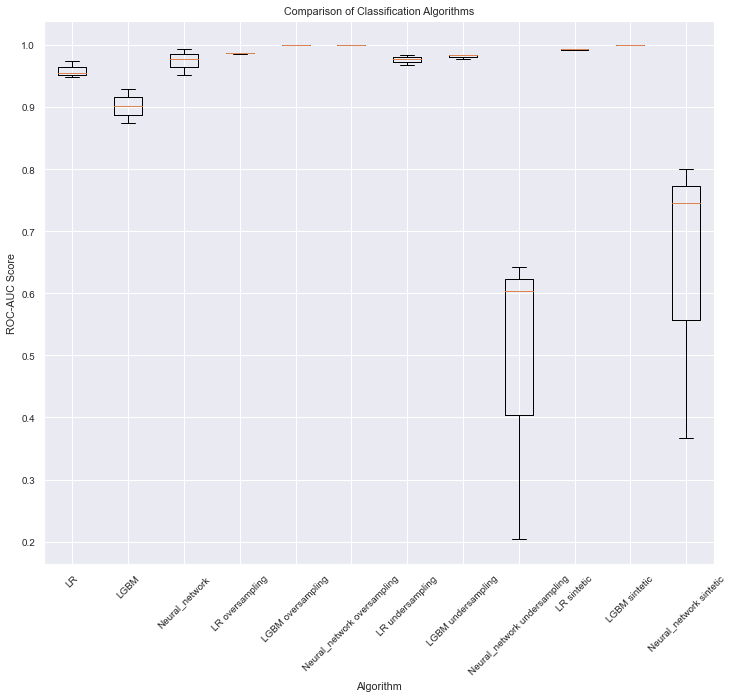

In [48]:
fig = plt.figure(figsize=(12, 10))

plt.title('Comparison of Classification Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('ROC-AUC Score')
plt.boxplot(accuracy_results, labels=names)
plt.xticks(rotation=45)

plt.show()

best model to conlitue, I would say LGBM trained on sintetic data. and further steps to find best params for this model

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56846
           1       0.76      0.78      0.77       116

    accuracy                           1.00     56962
   macro avg       0.88      0.89      0.88     56962
weighted avg       1.00      1.00      1.00     56962



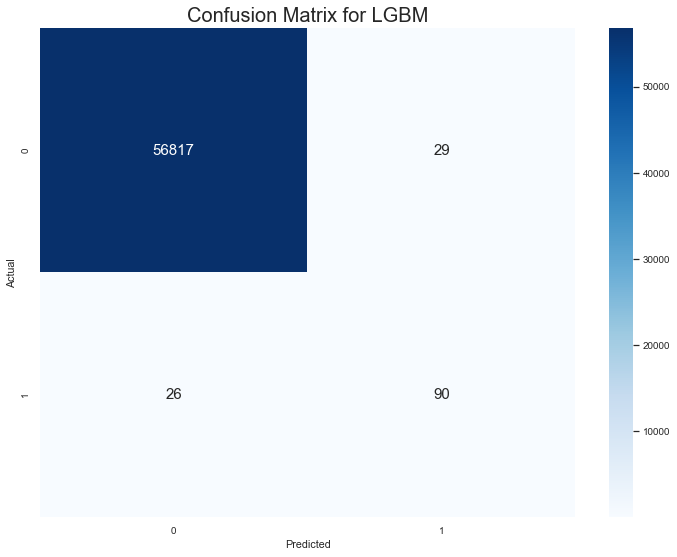

In [49]:
LGBM = LGBMClassifier()
LGBM = check_confusion_matrix(LGBM, X_resampled, X_test, y_resampled, y_test,
                              'LGBM')

for really good results we need to take
n_iter=200
cv = 7
but for saving time I used lower values

In [243]:
param_dist = {
    "max_depth": [10, 25, 50, 75],
    "learning_rate": [0.01, 0.05, 0.1],
    "num_leaves": [50, 100, 300, 900, 1200],
    "n_estimators": [50, 100, 200],
    'feature_fraction': [0.5, 0.8, 1],
    'bagging_fraction': [0.8, 0.9, 1]
}
lg_gs = RandomizedSearchCV(LGBM,
                           n_jobs=-1,
                           n_iter=20,
                           param_distributions=param_dist,
                           cv=3,
                           scoring="roc_auc",
                           verbose=5)

lg_gs.fit(X_resampled, y_resampled)
lg_gs.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 11.4min finished


LGBMClassifier(bagging_fraction=0.9, boosting_type='gbdt', class_weight=None,
               colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.05, max_depth=50,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=300, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56846
           1       0.89      0.79      0.84       116

    accuracy                           1.00     56962
   macro avg       0.95      0.90      0.92     56962
weighted avg       1.00      1.00      1.00     56962



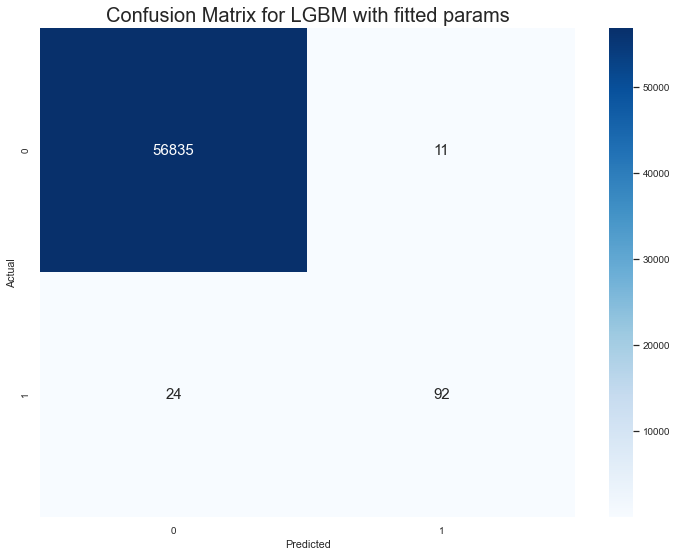

In [244]:
LGBM_best = lg_gs.best_estimator_
LGBM = check_confusion_matrix(LGBM_best, X_resampled, X_test, y_resampled,
                              y_test, 'LGBM with fitted params')

half of false positive resuls was fixed, but small degradation in true positive and false negative

now we can check model scores, maybe it can emprove results

In [302]:
predict_t = LGBM_best = lg_gs.best_estimator_.predict_proba(X_test)
predict_t = [p[1] for p in predict_t]
fpr, tpr, threshold = roc_curve(y_test, predict_t)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
optimal_threshold

3.6344942308988044e-05

In [303]:
predict_class = np.where(np.array(predict_t) > optimal_threshold, 1, 0)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56846
           1       0.04      0.91      0.08       116

    accuracy                           0.96     56962
   macro avg       0.52      0.94      0.53     56962
weighted avg       1.00      0.96      0.98     56962



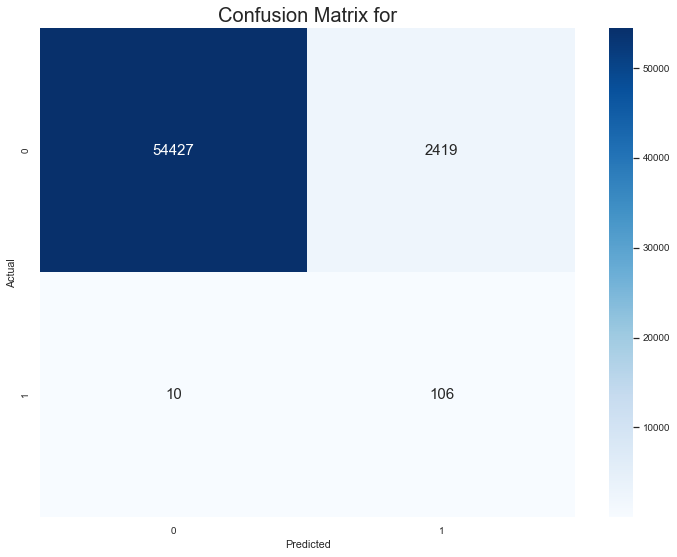

In [304]:
print(classification_report(y_test, predict_class))

confmat = confusion_matrix(y_true=y_test, y_pred=predict_class)
classes = ['0', '1']
df_cm = pd.DataFrame(confmat, columns=classes, index=classes)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize=(12, 9))

ax = plt.axes()
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 15}, fmt="d")
sns.set(font_scale=0.9)
ax.set_title('Confusion Matrix for', fontsize=20)
plt.show()

usually it improves model result, but in this case for now something went wrong

just to compare I will run NN with bigger number of iteration on oversampled data (but I guess there was just orevfitting)

In [20]:
ros = RandomOverSampler(sampling_strategy=.3, random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(y_resampled.value_counts() / y_resampled.shape[0])
print(X_resampled.shape)

idx = np.random.permutation(X_resampled.index)
X_resampled = X_resampled.reindex(idx)
y_resampled = y_resampled.reindex(idx)

0    0.769233
1    0.230767
Name: is_fraud, dtype: float64
(295709, 32)


In [57]:
x_train_nn, x_test_nn = pd.DataFrame(
    min_max_scaler.transform(X_resampled)), pd.DataFrame(
        min_max_scaler.transform(X_test))

Train on 295709 samples
Epoch 1/10
295709/295709 [==============================] - 24s 80us/sample - loss: 0.0275 - AUC: 0.9989s - loss: 0.0376 - - ETA: 8s - loss: 0.0366 - - ETA: 7s - loss: 0.035 - ETA: 7s - l - ETA: 5s - loss: 0.0329 - A - ET - ETA: 3s - loss: 0.0305 - AUC: 0.998 - ETA: 3s - loss: 0.0304 - AUC - ETA: 3s - loss: 0.0301 - AUC: 0. - - ETA: 0s - loss: 0.02
Epoch 2/10
295709/295709 [==============================] - 23s 79us/sample - loss: 0.0072 - AUC: 0.9997
Epoch 3/10
295709/295709 [==============================] - 24s 82us/sample - loss: 0.0052 - AUC: 0.9998s - loss: 0.00
Epoch 4/10
295709/295709 [==============================] - 22s 76us/sample - loss: 0.0043 - AUC: 0.9998
Epoch 5/10
295709/295709 [==============================] - 23s 78us/sample - loss: 0.0041 - AUC: 0.9998ETA: 0s - loss: 0.00 - ETA: 0s - loss: 0.0040 - AUC: 0.9
Epoch 6/10
295709/295709 [==============================] - 23s 76us/sample - loss: 0.0035 - AUC: 0.9999s - loss: 0.0035 - AUC: 0.9
Epo

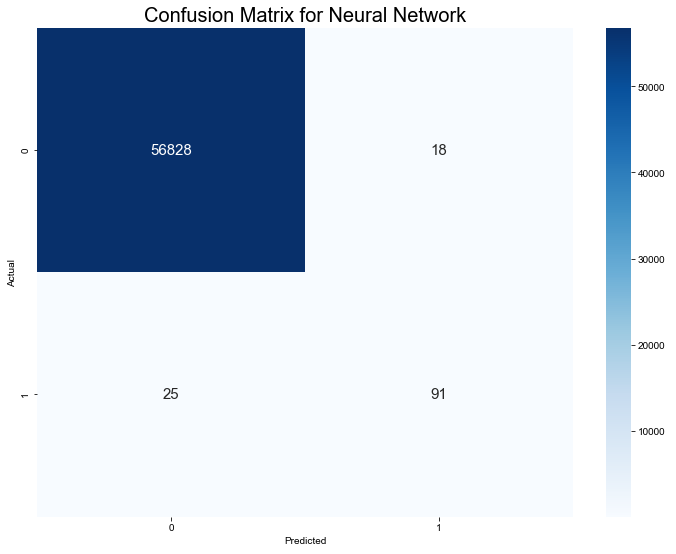

In [24]:
NN = Neural_Network()
NN.epoch = 10

check_confusion_matrix(NN, x_train_nn, x_test_nn, y_resampled, y_test,
                       'Neural Network')